In here we tried to perform the model on lsoa level, summerzing all the sentences vectors within one lsoa, use these to predict gentrification.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score

In [43]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25_only.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [44]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")
print(stru_data.columns)

Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [45]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [46]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [47]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
import ast
from shapely.geometry import Polygon
import geopandas as gpd

# 1. 去掉空值
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()

# 2. 如果是字符串形式的 list，先转为真正的 list
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(
    lambda coords: Polygon(ast.literal_eval(coords)[0]) if isinstance(coords, str) else Polygon(coords[0])
)

# 3. 创建 GeoDataFrame，设置坐标系
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [48]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [49]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate", 
                                          "price_grow", "avg_den", "senior_per", "minority_per"]], 
                                          how="left", predicate="within")

In [50]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [51]:
# spatial join
joined = gpd.sjoin(gdf_27700, lsoa_label, how="left", predicate="within")

In [52]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate", 
                                                                            "price_grow", "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [53]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'geometry', 'centroid', 'index_right', 'LSOA code', 'gentrified',
       'pop_growth_rate', 'price_grow', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=411)

In [54]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

<Axes: >

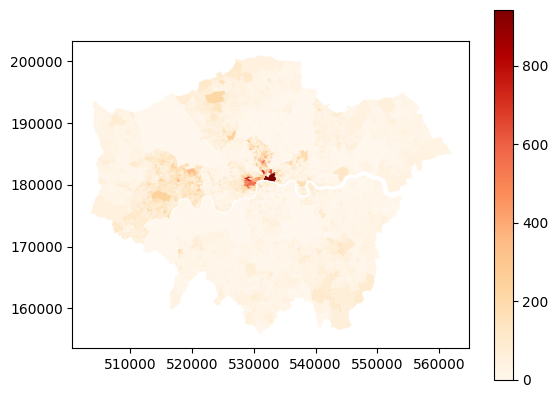

In [55]:
# gdf_lsoa: 是你读取的 LSOA 边界数据
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')
lsoa_label['application_count'] = lsoa_label['application_count'].fillna(0).astype(int)

# 地图可视化
lsoa_label.plot(column='application_count', cmap='OrRd', legend=True)


In [56]:
print(lsoa_counts.head(5))

   LSOA code  application_count
0  E01000001                 48
1  E01000002                 87
2  E01000003                 34
3  E01000005                 98
4  E01000006                  1


In [57]:
# 按 LSOA 编码分组，取均值（你也可以试试 sum、max 等方式）
sbert_cols = [f"sbert_{i}" for i in range(384)]
lsoa_vecs = joined_cleaned.groupby("LSOA code")[sbert_cols].mean()

# struct_cols = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per']
# lsoa_struct = joined_cleaned.groupby("LSOA code")[struct_cols].mean()

# lsoa_combined = lsoa_vecs.join(lsoa_struct, how='left')

# lsoa_label = joined_cleaned[['LSOA code', 'gentrified']].drop_duplicates()
# lsoa_combined = lsoa_combined.reset_index().merge(lsoa_label, on="LSOA code", how="left")


In [86]:
joined_cleaned.head

<bound method NDFrame.head of                                                 site_name decision_date  \
0                                                            2016-05-26   
1                                        Residential Unit    2015-10-28   
2                                                            2015-05-12   
3                                    McDonalds Restaurant    2015-07-03   
4                                                            2015-10-19   
...                                                   ...           ...   
192565                     140 Bruce Road, London, E3 3EU    2019-06-17   
192568                      11 Rum Close, London, E1W 3QX    2019-06-24   
192578  Site On East Side North Of Railway Bridge Betw...    2020-04-28   
192579  Calders Wharf, Saunders Ness Road, London, E14...    2019-09-24   
192581               82 West India Dock Road, London, E14    2019-10-21   

       valid_date                                 polygon.geometries 

# SBERT + KMEANs

In [28]:
print(joined_cleaned.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'centroid', 'index_right', 'LSOA code', 'gentrified', 'pop_growth_rate',
       'price_grow', 'avg_den', 'senior_per', 'minority_per', 'text_cluster'],
      dtype='object', length=412)


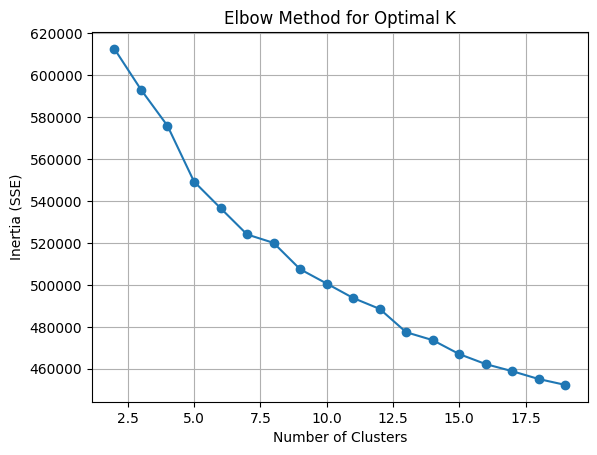

In [22]:
# 试试kmean 聚类

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

joined_cleaned['gentrified'] = joined_cleaned['gentrified'].astype(int)

# Step 1: 取出 SBERT 向量列（你有384维）
sbert_cols = [col for col in joined_cleaned.columns if col.startswith('sbert_')]
X_embed = joined_cleaned[sbert_cols]

inertias = []
cluster_range = range(2, 20)  # 一般选 2~15

for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_embed)
    inertias.append(km.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [26]:
# Step 2: 聚类， 根据之前的结果可以选6或11
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
joined_cleaned['text_cluster'] = kmeans.fit_predict(X_embed)

# Step 3: One-hot 编码这些 cluster（也可以直接用 cluster label）
onehot = pd.get_dummies(joined_cleaned['text_cluster'], prefix='anchor_cluster')

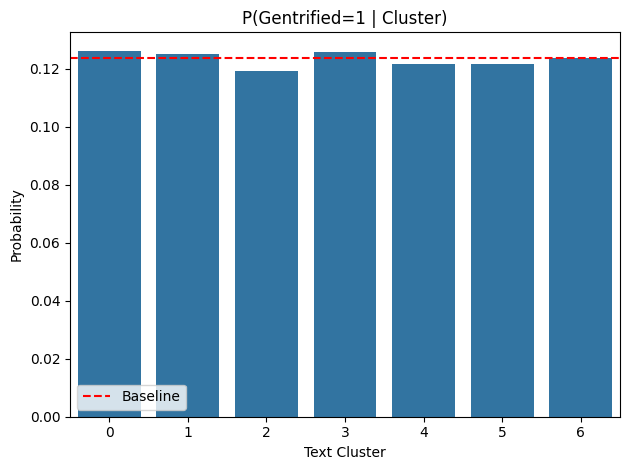

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_g = joined_cleaned.groupby('text_cluster')['gentrified'].mean().sort_values()

sns.barplot(x=cluster_g.index, y=cluster_g.values)
plt.title("P(Gentrified=1 | Cluster)")
plt.ylabel("Probability")
plt.xlabel("Text Cluster")
plt.axhline(y=joined_cleaned['gentrified'].mean(), color='red', linestyle='--', label='Baseline')
plt.legend()
plt.tight_layout()
plt.show()

# SBERT

In [ ]:
# anchor_dict = {
#     "residential": ["flat conversion", "refurbishment", "rear extension", 
#                     "erection of storey", "demolition of exsiting rear", "alterations",
#                     "replacement", "installation", "windows"],
#     "commercial": ["coffee shop", "illuminated sign", "retail upgrade", 
#                    "change use", "fascia", "digital screen"],
#     "green": ["park improvement", "landscaping", "tree planting"],
#     "cultural": ["artist studios", "cultural space", "gallery conversion"],
#     "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", 
#                        "cycle", "parking", "lighting repalcement", "antennas", "public"]
# }
# sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# # 正确计算平均向量：
# anchor_vecs = {
#     k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
# }

In [ ]:
anchor_dict = {
    "residential": ["flat conversion", "refurbishment", "rear extension", 
                    "erection of storey", "demolition of exsiting rear", "alterations",
                    "replacement", "installation", "windows"],
    "commercial": ["coffee shop", "illuminated sign", "retail upgrade", 
                   "change use", "fascia", "digital screen"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", 
                       "cycle", "parking", "lighting repalcement", "antennas", "public"]
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# 正确计算平均向量：
anchor_vecs = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
}

In [59]:
# from sklearn.metrics.pairwise import cosine_similarity

# # 示例：一列句子向量 (shape: N x 384)，和 5 个 anchor (5 x 384)
# sent_vecs = lsoa_combined[[f"sbert_{i}" for i in range(384)]].values
# anchor_vecs_matrix = np.vstack([anchor_vecs[a] for a in anchor_dict])  # shape: 5 x 384

# # 计算所有句子对所有 anchor 的相似度
# sim_matrix = cosine_similarity(sent_vecs, anchor_vecs_matrix)  # shape: N x 5

# # 加入列名
# sim_df = pd.DataFrame(sim_matrix, columns=[f"sim_{a}" for a in anchor_dict])
# lsoa_combined = pd.concat([lsoa_combined.reset_index(drop=True), sim_df], axis=1)


In [60]:
# print(lsoa_combined.shape)

In [61]:
# features = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per', 
#             'sim_residential', 'sim_commercial', 'sim_green', 'sim_cultural', 'sim_infrustructure']
# lsoa_combined['gentrified'] = lsoa_combined['gentrified'].astype(int)

# X = lsoa_combined[features]
# y = lsoa_combined['gentrified']

# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report

# # 样本不均衡处理
# scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model.fit(X_train, y_train)

# print(classification_report(y_test, model.predict(X_test)))

In [62]:
# print(scale_pos_weight)

In [63]:
# X_base = lsoa_combined[struct_cols]
# y_base = lsoa_combined['gentrified']

# X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, stratify=y_base, test_size=0.2, random_state=42)

# model_base = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model_base.fit(X_base_train, y_base_train)

# print(classification_report(y_base_test, model_base.predict(X_base_test)))

In [64]:
# # feature importance
# from xgboost import plot_importance

# plt.figure(figsize=(10, 6))
# plot_importance(model, importance_type='gain', max_num_features=10)
# plt.title("Top 10 Important Features (by Gain)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# def extract_diverse_anchor_sentences(
#     anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
#     all_sentences,         # 句子列表: List[str]
#     sbert_model,           # SentenceTransformer 模型
#     topk,               # 每个 anchor 最多考虑 topk 相似句子作为候选
#     anchor_threshold,  # anchor 与句子相似度下限
#     sim_threshold     # 被选句子之间最大相似度（越小越多样）
# ):
#     # 编码所有句子为向量
#     print("emcoding all sentences...")
#     sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     anchor_top_sentences = {}

#     for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
#         sims = cosine_similarity([anchor_vec], sent_vecs)[0]

#         # 找出相似度高于 anchor_threshold 的 topk 句子
#         sorted_idx = np.argsort(sims)[::-1]
#         filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

#         selected = []
#         selected_vecs = []

#         for i in filtered_idx:
#             sent = all_sentences[i]
#             vec = sent_vecs[i]

#             # 判断与已选句子的相似度是否都低于 sim_threshold
#             if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
#                 selected.append({"sentence": sent, "score": float(sims[i])})
#                 selected_vecs.append(vec)

#         anchor_top_sentences[cat] = selected
#         print(f"✅ {cat}: select {len(selected)} sentences")

#     return anchor_top_sentences

In [87]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

def extract_diverse_anchor_sentences(anchor_vecs, all_sentences, sbert_model, topk=10, anchor_threshold=0.6, sim_threshold=0.85):
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=False)
    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 Extracting anchors"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            vec = sent_vecs[i]
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": all_sentences[i], "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
    return anchor_top_sentences

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
joined_cleaned['y'] = joined_cleaned['gentrified'].astype(int)

# ✅ flatten 工具函数，处理 numpy array / list / string
def flatten_text(x):
    if isinstance(x, (np.ndarray, list)):
        if len(x) > 0:
            return str(x[0])
        else:
            return ""  # 空数组返回空字符串或 None
    elif isinstance(x, str):
        return x
    else:
        return str(x)


for fold, (train_idx, test_idx) in enumerate(kf.split(joined_cleaned, joined_cleaned['y']), 1):
    print(f"\n====== Fold {fold} ======")

    # 拆分训练和测试集
    df_train = joined_cleaned.iloc[train_idx]
    df_test = joined_cleaned.iloc[test_idx]

    # ✅ 提取训练集中正类的句子，并处理格式
    positive_sentences = (
        df_train[df_train['y'] == 1]['sentences']
        .dropna()
        .apply(flatten_text)
        .tolist()
    )

    # ✅ 从正类句子中提取多样化高相似 keylines（作为新的 anchor）
    anchor_sentences = extract_diverse_anchor_sentences(
        anchor_vecs,
        positive_sentences,
        sbert_model,
        topk=10,
        anchor_threshold=0.6,
        sim_threshold=0.85
    )

    # ✅ 对所有句子重新打分（train + test）
    full_sentences = joined_cleaned['sentences'].dropna().apply(flatten_text).tolist()
    full_vecs = sbert_model.encode(full_sentences, batch_size=32, show_progress_bar=False)

    for cat, anchor_list in anchor_sentences.items():
        anchor_sents = [x['sentence'] for x in anchor_list]
        if not anchor_sents:
            print(f"⚠️ No anchor sentences found for category: {cat}")
            joined_cleaned[f"{cat}_sim_fold{fold}"] = np.nan
            continue

        anchor_vec_set = sbert_model.encode(anchor_sents, batch_size=32)
        sims = cosine_similarity(full_vecs, anchor_vec_set).max(axis=1)

        # ✅ 写入特征列
        joined_cleaned[f"{cat}_sim_fold{fold}"] = sims

    print(f"✅ Fold {fold} features done.")



====== Fold 1 ======


🔍 Extracting anchors: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


KeyboardInterrupt: 

In [82]:
# 强制转成字符串 & 去除缺失值
all_sentences = joined_cleaned['sentences'].dropna().astype(str).tolist()

In [85]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,
    all_sentences=all_sentences ,
    sbert_model=sbert_model,
    topk=50,
    anchor_threshold=0.6, # 0.5
    sim_threshold=0.85 #0.7
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pickle

with open("diverse_anchor_results_s.pkl", "wb") as f:
    pickle.dump(diverse_results, f)

In [ ]:
with open("diverse_anchor_results_s.pkl", "rb") as f:
    diverse_results = pickle.load(f)

In [ ]:
for i, item in enumerate(diverse_results["cultural"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. ['Conversion of garage into a playroom/study involving the insertion of a window and a door into front elevation']  (similarity: 0.60)
2. ['Conversion of an end-terrace garage into a habitable room for use as a music studio; and single-storey front extension of garage']  (similarity: 0.60)
3. ['Construction of 15 no.'
 "new artist's studios in three levels with new access platforms and stairs from reconditioned shipping containers to be sited on the vacant front forecourt of Action House."
 '(total area created 195sm2)']  (similarity: 0.59)
4. ['Erection of an annexe extension with Art studios and store areas to existing Adult & Community Education Centre']  (similarity: 0.59)
5. ['Reconfiguration of the Great Chamber and Ante-Room as a portrait gallery and interpretation, redecoration, new floor and wall finishes, reservicing and relighting.']  (similarity: 0.58)
6. ['Installation of Community artwork.']  (similarity: 0.57)
7. ['CONVERSION OF GARAGE AS A STORAGE AND OFFICE FOR THE 

In [ ]:
# ⚙️ 不求平均，保留所有向量作为每类 anchor 的“多中心表示”
anchor_vecs_multi = {}
for cat, items in diverse_results.items():
    sentences = [entry["sentence"] for entry in items]
    vecs = sbert_model.encode(sentences, batch_size=32)
    anchor_vecs_multi[cat] = vecs

In [ ]:
def score_sentences_against_multi_anchors(anchor_vecs, all_sentences, sbert_model):
    print("encoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    scores = {}
    for cat, anchor_vec_list in anchor_vecs.items():
        # anchor_vec_list: shape = (n_anchor_sents, dim)
        sims = cosine_similarity(anchor_vec_list, sent_vecs)  # shape = (n_anchor_sents, n_all_sents)
        scores[cat] = sims.max(axis=0)  # 或用 sims.mean(axis=0)

    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences
    return score_df

In [ ]:
score_df = score_sentences_against_multi_anchors(
    anchor_vecs=anchor_vecs_multi,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [ ]:
# 加上 LSOA code（确保顺序匹配）
score_df['LSOA code'] = joined_cleaned['LSOA code'].values

# 只保留数值列（通常是 anchor 类别的列）
anchor_score_numeric = score_df.select_dtypes(include='number')

# 添加 LSOA code 回来做分组
anchor_score_numeric['LSOA code'] = score_df['LSOA code']

In [70]:
score_df.to_csv("data/score_df_85.csv")

In [83]:
print(score_df)

        residential  commercial     green  cultural  infrustructure  \
0          0.412703    0.249340  0.291362  0.345742        0.446543   
1          0.543195    0.250134  0.509685  0.492026        0.449628   
2          0.563165    0.210611  0.326052  0.450688        0.397673   
3          0.368364    0.609045  0.353166  0.418836        0.657180   
4          0.342973    0.410326  0.290711  0.557229        0.608145   
...             ...         ...       ...       ...             ...   
155362     0.171435    0.179321  0.135539  0.226568        0.361174   
155363     0.686710    0.433803  0.523267  0.552904        0.577236   
155364     0.606651    0.293666  0.429066  0.486503        0.489080   
155365     0.269870    0.117431  0.207609  0.250262        0.414124   
155366     0.337590    0.189124  0.250190  0.274648        0.539632   

                                                 sentence  LSOA code  
0       ['Certificate of Lawfulness in connection with...  E01002714  
1    

In [ ]:
import pandas as pd

# 设置你要保留的 anchor 列和 top-N 值
anchor_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']
top_n = 5  # 每个 LSOA 只保留相似度最高的 5 条句子

# 确保 score_df 里有 'LSOA code' 和 anchor 得分
score_df['LSOA code'] = joined_cleaned['LSOA code'].values

# 定义函数：对每个 LSOA, anchor 取 top-N 后聚合
def top_n_mean(df, anchor, n=5):
    return (
        df.sort_values(by=anchor, ascending=False)
          .head(n)[anchor]
          .mean()
    )

# 建立结果 DataFrame
lsoa_list = score_df['LSOA code'].unique()
topn_dict = {'LSOA code': []}
for anchor in anchor_cols:
    topn_dict[anchor + '_topn_mean'] = []

# 遍历每个 LSOA 和 anchor 聚合
for lsoa in lsoa_list:
    topn_dict['LSOA code'].append(lsoa)
    lsoa_df = score_df[score_df['LSOA code'] == lsoa]
    for anchor in anchor_cols:
        val = top_n_mean(lsoa_df, anchor, n=top_n)
        topn_dict[anchor + '_topn_mean'].append(val)
z
# 转为 DataFrame
anchor_lsoa_topn = pd.DataFrame(topn_dict)

KeyError: 'residential_mean'

In [29]:
print(anchor_lsoa_topn.head(5))

   LSOA code  residential_topn_mean  commercial_topn_mean  green_topn_mean  \
0  E01002714               0.765265              0.626260         0.700867   
1  E01002771               0.747451              0.558030         0.683054   
2  E01000220               0.687042              0.411908         0.511596   
3  E01001220               0.690279              0.603397         0.555940   
4  E01003187               0.541746              0.424574         0.357311   

   cultural_topn_mean  infrustructure_topn_mean  
0            0.644490                  0.681251  
1            0.608008                  0.629741  
2            0.600689                  0.573306  
3            0.596447                  0.634507  
4            0.514902                  0.482219  


In [ ]:
anchor_lsoa_topn.to_csv("data/anchor_similarity_scores_mean.csv", index=False)

In [ ]:
# 1️⃣ 按 LSOA 聚合每类 anchor 得分总和
anchor_sums = score_df.groupby("LSOA code")[anchor_cols].sum().reset_index()

# 2️⃣ 重命名列名，加上 _sum 后缀（更明确）
anchor_sums.rename(columns={col: col + "_sum" for col in anchor_cols}, inplace=True)

# 3️⃣ 输出
anchor_lsoa_sum = anchor_sums

# 预览结果
print(anchor_lsoa_sum.head())

   LSOA code  residential_sum  commercial_sum  green_sum  cultural_sum  \
0  E01000001        23.645973       18.562317  20.630339     20.113354   
1  E01000002        38.837772       30.800552  36.668304     32.152813   
2  E01000003        15.090670       10.165207  14.278521     11.345996   
3  E01000005        40.713188       34.940998  39.473312     32.901390   
4  E01000006         0.852195        0.300086   0.632047      0.554059   

   infrustructure_sum  
0           14.504108  
1           25.891804  
2           10.191477  
3           27.702251  
4            0.252611  


In [ ]:
anchor_lsoa_sum.to_csv("data/anchor_similarity_scores_sum_s.csv", index=False)

In [31]:
anchor_lsoa_topn['total_topn_score'] = anchor_lsoa_topn[
    ['residential_topn_mean', 'commercial_topn_mean', 'green_topn_mean',
     'cultural_topn_mean', 'infrustructure_topn_mean']].sum(axis=1)

In [32]:
anchor_lsoa_sum['total_sum_score'] = anchor_lsoa_sum[
    ['residential_sum', 'commercial_sum', 'green_sum',
     'cultural_sum', 'infrustructure_sum']].sum(axis=1)

In [ ]:
# 把结构变量也合并进来（你之前好像从 lsoa_label 或其他来源获得
# topn平均值
final_df_mean = pd.merge(anchor_lsoa_topn, lsoa_label[['LSOA code', 'gentrified', 'application_count',
                                                        'avg_den', 'pop_growth_rate', 'senior_per', 'minority_per',
                                                        'all_dwelling', 'shared_per', 'converted_per',
                                                        'level_4_pop', 'level_4_per',
                                                        'prof_occ_count', 'prof_occ_per']], 
                                            on='LSOA code')

In [34]:
# 得分总和
final_df_sum = pd.merge(anchor_lsoa_sum, lsoa_label[['LSOA code', 'gentrified', 'application_count',
                                                    'avg_den', 'pop_growth_rate', 'senior_per', 'minority_per',
                                                    'all_dwelling', 'shared_per', 'converted_per',
                                                    'level_4_pop', 'level_4_per',
                                                    'prof_occ_count', 'prof_occ_per']], 
                                                on='LSOA code')

In [35]:
print(final_df_sum.shape)

(4271, 20)


In [36]:
final_df_sum.to_csv("lsoa_model_dataframe_sum.csv", index=False)

In [39]:
# 平均值
features_mean = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per', 
                'all_dwelling', 'shared_per', 'converted_per',
                'level_4_pop', 'level_4_per',
                'prof_occ_count', 'prof_occ_per',
                'residential_topn_mean', 'commercial_topn_mean', 'green_topn_mean', 'cultural_topn_mean', 'infrustructure_topn_mean', 
                'application_count','total_topn_score']
base = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per',
        'all_dwelling', 'shared_per', 'converted_per',
        'level_4_pop', 'level_4_per',
        'prof_occ_count', 'prof_occ_per']

In [40]:
final_df_mean.groupby('gentrified')[features_mean].describe()

pop_growth_rate                                                    \
                     count      mean       std       min       25%       50%   
gentrified                                                                     
False               4031.0  0.031951  0.094520 -0.405805 -0.012574  0.015172   
True                 240.0  0.051681  0.117081 -0.298763 -0.005060  0.023187   

                               avg_den                ... application_count  \
                 75%       max   count          mean  ...               75%   
gentrified                                            ...                     
False       0.050659  1.688833  4031.0  10268.589689  ...              40.0   
True        0.071490  0.855359   240.0  12291.068545  ...              41.5   

                  total_topn_score                                          \
              max            count      mean       std       min       25%   
gentrified                                                                   
False       942.0           4031.0  2.604719  0.401360  0.642356  2.375312   
True        551.0            240.0  2.537882  0.443775  1.086804  2.256272   

                                          
                 50%       75%       max  
gentrified                                
False       2.657755  2.868403  3.651227  
True        2.562526  2.869162  3.551898  

[2 rows x 144 columns]

In [41]:
# 总和
features_sum = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per', 
                'application_count', 'total_sum_score',
                'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per', 
                'all_dwelling', 'shared_per', 'converted_per',
                'level_4_pop', 'level_4_per',
                'prof_occ_count', 'prof_occ_per']

In [42]:
final_df_sum.groupby('gentrified')[features_sum].describe()

pop_growth_rate                                                    \
                     count      mean       std       min       25%       50%   
gentrified                                                                     
False               4031.0  0.031951  0.094520 -0.405805 -0.012574  0.015172   
True                 240.0  0.051681  0.117081 -0.298763 -0.005060  0.023187   

                               avg_den                ... prof_occ_count  \
                 75%       max   count          mean  ...            75%   
gentrified                                            ...                  
False       0.050659  1.688833  4031.0  10268.589689  ...          243.0   
True        0.071490  0.855359   240.0  12291.068545  ...          202.5   

                  prof_occ_per                                               \
              max        count       mean       std  min   25%    50%   75%   
gentrified                                                                    
False       602.0       4031.0  21.673778  7.989136  5.9  15.0  20.70  27.6   
True        403.0        240.0  19.976250  7.241724  6.1  14.3  18.35  24.1   

                  
             max  
gentrified        
False       50.4  
True        43.0  

[2 rows x 136 columns]

In [ ]:
final_df_sum.shape

In [74]:
# 特征和标签
X = final_df_mean[features_mean]
y = final_df_mean['gentrified'].astype(int)

# 初始化评估器
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls = [], [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 可选：自动设置 scale_pos_weight
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    # sample_weight = np.where(y_train == 1, 8.0, 1.0)

    model = XGBClassifier(
        random_state=42,
        # sample_weight=sample_weight,
        objective='binary:logistic',
        scale_pos_weight = scale_pos_weight*2,
        eval_metric='logloss',
        max_delta_step=1,             # ✅ 让每棵树的更新更稳健
        learning_rate=0.05,           # ✅ 低学习率有助稳定少数类识别
        n_estimators=200 
    )

    model.fit(X_train.values, y_train)
    y_proba = model.predict_proba(X_test.values)[:, 1]  # 概率预测正类
    threshold = 0.5  
    y_pred = (y_proba >= threshold).astype(int)


    # 评估
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    f1s.append(f1_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))

    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)
    gmean_scores.append(gmean)

# 汇总平均结果
print("Cross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average AUROC: {np.mean(auc_scores):.4f}")
print(f"Average Log-loss: {np.mean(logloss_scores):.4f}")
print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")


Cross-Validation Summary:
Average Accuracy: 0.8651
Average AUROC: 0.6428
Average Log-loss: 0.3324
Average G-mean:     0.4269
Average F1-score:   0.1452
Average Recall:     0.2037


In [73]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.5, 30)
f1_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best F1: {max(f1_scores):.4f} at threshold: {best_threshold:.2f}")

Best F1: 0.1895 at threshold: 0.50


C:\Users\hp\AppData\Local\Temp\ipykernel_3368\876960543.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (prec * recall) / (prec + recall)


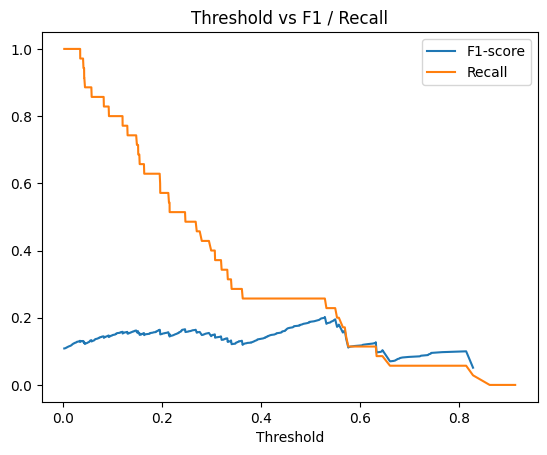

In [75]:
from sklearn.metrics import precision_recall_curve

prec, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * recall) / (prec + recall)

plt.plot(thresholds, f1[:-1], label='F1-score')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Threshold vs F1 / Recall")
plt.show()

In [137]:
from imblearn.over_sampling import SMOTE

acc_scores, auc_scores, logloss_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    print(f"Fold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 上采样：只在训练集上做 SMOTE，防止泄漏
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # 构建防过拟合的 XGBoost 模型
    model = XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=3,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0
    )

    model.fit(X_train_resampled, y_train_resampled)

    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.05
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)

    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)

    print(f"  Accuracy: {acc:.4f} | AUROC: {auc:.4f} | Log-loss: {ll:.4f}")
    print(classification_report(y_test, y_pred))

print("Cross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average AUROC: {np.mean(auc_scores):.4f}")
print(f"Average Log-loss: {np.mean(logloss_scores):.4f}")


Fold 1
  Accuracy: 0.1836 | AUROC: 0.5568 | Log-loss: 0.5329
              precision    recall  f1-score   support

           0       0.96      0.14      0.25       807
           1       0.06      0.90      0.11        48

    accuracy                           0.18       855
   macro avg       0.51      0.52      0.18       855
weighted avg       0.91      0.18      0.24       855

Fold 2
  Accuracy: 0.1897 | AUROC: 0.5852 | Log-loss: 0.5171
              precision    recall  f1-score   support

           0       0.97      0.15      0.25       806
           1       0.06      0.94      0.12        48

    accuracy                           0.19       854
   macro avg       0.52      0.54      0.18       854
weighted avg       0.92      0.19      0.24       854

Fold 3
  Accuracy: 0.2365 | AUROC: 0.5391 | Log-loss: 0.5136
              precision    recall  f1-score   support

           0       0.93      0.21      0.34       806
           1       0.05      0.73      0.10        48


In [138]:
X_base = final_df_sum[base]
y_base = final_df_sum['gentrified'].astype(int)

# 初始化评估器
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, auc_scores, logloss_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    print(f"Fold {fold}")

    X_base_train, X_base_test = X_base.iloc[train_idx], X_base.iloc[test_idx]
    y_base_train, y_base_test = y_base.iloc[train_idx], y_base.iloc[test_idx]

    # 可选：自动设置 scale_pos_weight
    scale_pos_weight = len(y_base_train[y_base_train == 0]) / len(y_base_train[y_base_train == 1])

    model_base = XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='logloss',
    )

    model_base.fit(X_base_train, y_base_train)
    y_base_proba = model_base.predict_proba(X_base_test)[:, 1]  # 概率预测正类
    threshold = 0.05  
    y_base_pred = (y_base_proba >= threshold).astype(int)


    # 评估
    acc = accuracy_score(y_base_test, y_base_pred)
    auc = roc_auc_score(y_base_test, y_base_proba)
    ll = log_loss(y_base_test, y_base_proba)

    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)

    print(f"  Accuracy: {acc:.4f} | AUROC: {auc:.4f} | Log-loss: {ll:.4f}")
    print(classification_report(y_base_test, y_base_pred))

# 汇总平均结果
print("Cross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average AUROC: {np.mean(auc_scores):.4f}")
print(f"Average Log-loss: {np.mean(logloss_scores):.4f}")

Fold 1
  Accuracy: 0.6901 | AUROC: 0.5462 | Log-loss: 0.3077
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       807
           1       0.06      0.31      0.10        48

    accuracy                           0.69       855
   macro avg       0.50      0.51      0.46       855
weighted avg       0.90      0.69      0.77       855

Fold 2
  Accuracy: 0.6674 | AUROC: 0.6565 | Log-loss: 0.2726
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       806
           1       0.09      0.54      0.15        48

    accuracy                           0.67       854
   macro avg       0.53      0.61      0.47       854
weighted avg       0.91      0.67      0.76       854

Fold 3
  Accuracy: 0.6838 | AUROC: 0.5627 | Log-loss: 0.3249
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       806
           1       0.08      0.46      0.14        48


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, classification_report, f1_score
import numpy as np

# 1. 特征与标签
X = final_df[features]
y = final_df['gentrified'].astype(int)

# 2. 创建 pipeline：undersampling + XGBoost

pipeline = Pipeline([
    ("undersample", RandomUnderSampler(random_state=42)),
    ("clf", XGBClassifier(scale_pos_weight=1,  # 不需要 scale_pos_weight，因为已经下采样
                          random_state=42, 
                          eval_metric="aucpr"))
])

# 3. Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 交叉验证评估：使用 F1-score（重点关注 minority class）
scores = cross_val_score(pipeline, X, y, 
                         scoring=make_scorer(f1_score, pos_label=1), 
                         cv=cv)

print("F1 score for minority class (gentrified=1) across 5 folds:")
print("Scores:", np.round(scores, 4))
print("Mean F1 score:", np.round(scores.mean(), 4))

F1 score for minority class (gentrified=1) across 5 folds:
Scores: [0.1128 0.1409 0.1304 0.1241 0.1429]
Mean F1 score: 0.1302


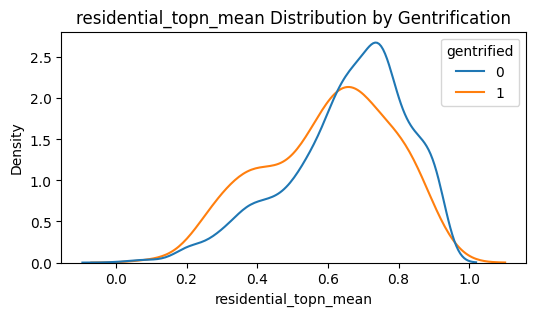

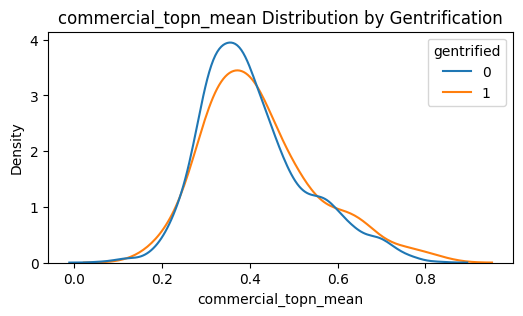

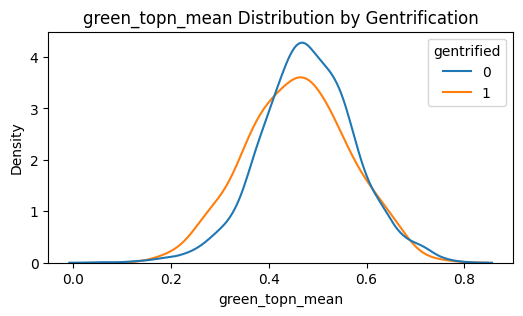

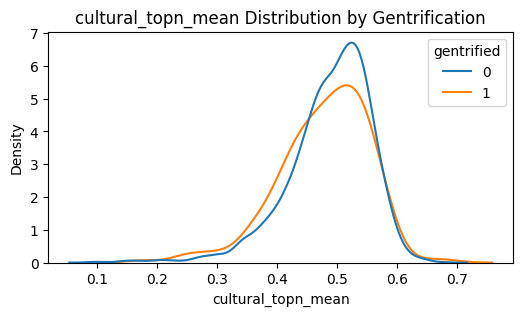

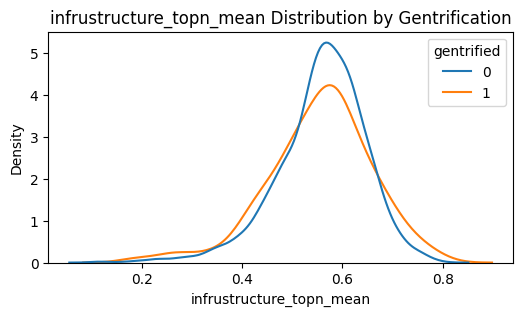

In [ ]:
anchor_cols = ['residential_topn_mean', 'commercial_topn_mean', 'green_topn_mean', 'cultural_topn_mean', 'infrustructure_topn_mean']

for col in anchor_cols:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=final_df, x=col, hue='gentrified', common_norm=False)
    plt.title(f"{col} Distribution by Gentrification")
    plt.show()

In [ ]:
X = final_df[features]
y = final_df['gentrified']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                                                            stratify=y_resampled, 
                                                                                            test_size=0.25, 
                                                                                            random_state=42)

scale_pos_weight = len(y_resampled_train[y_resampled_train == 0]) / len(y_resampled_train[y_resampled_train == 1])

model_resampled = XGBClassifier(scale_pos_weight = scale_pos_weight,
                      random_state=42, 
                      eval_metric="aucpr")

model_resampled.fit(X_resampled_train, y_resampled_train)

# Evaluate
y_resampled_pred = model_resampled.predict(X_resampled_test)
print(classification_report(y_resampled_test, y_resampled_pred))
y_resampled_proba = model_resampled.predict_proba(X_resampled_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_resampled_test, y_resampled_proba))
print("AUPRC:", average_precision_score(y_resampled_test, y_resampled_proba))


              precision    recall  f1-score   support

           0       0.53      0.48      0.50        60
           1       0.52      0.57      0.54        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.52       120
weighted avg       0.53      0.53      0.52       120

AUROC: 0.5900000000000001
AUPRC: 0.6494055326948425


In [ ]:
X = final_df[features]
y = final_df['gentrified']


from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                                                            stratify=y_resampled, 
                                                                                            test_size=0.25, 
                                                                                            random_state=42)

scale_pos_weight = len(y_resampled_train[y_resampled_train == 0]) / len(y_resampled_train[y_resampled_train == 1])

model_resampled = XGBClassifier(scale_pos_weight = scale_pos_weight,
                      random_state=42, 
                      eval_metric="aucpr")

model_resampled.fit(X_resampled_train, y_resampled_train)

y_resampled_pred = model_resampled.predict(X_resampled_test)
print("TEST")
print(classification_report(y_resampled_test, y_resampled_pred))
y_resampled_proba = model_resampled.predict_proba(X_resampled_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_resampled_test, y_resampled_proba))
print("AUPRC:", average_precision_score(y_resampled_test, y_resampled_proba))

y_resampled_pred_train = model_resampled.predict(X_resampled_train)
y_resampled_proba_train = model_resampled.predict_proba(X_resampled_train)[:, 1]
print("TRAIN")
print(classification_report(y_resampled_train, y_resampled_pred_train))
print("Train AUROC:", roc_auc_score(y_resampled_train, y_resampled_proba_train))
print("Train AUPRC:", average_precision_score(y_resampled_train, y_resampled_proba_train))

TEST
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1008
           1       0.97      1.00      0.98      1008

    accuracy                           0.98      2016
   macro avg       0.98      0.98      0.98      2016
weighted avg       0.98      0.98      0.98      2016

AUROC: 0.9992815413202318
AUPRC: 0.998949371212279
TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3023
           1       1.00      1.00      1.00      3023

    accuracy                           1.00      6046
   macro avg       1.00      1.00      1.00      6046
weighted avg       1.00      1.00      1.00      6046

Train AUROC: 1.0
Train AUPRC: 1.0


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

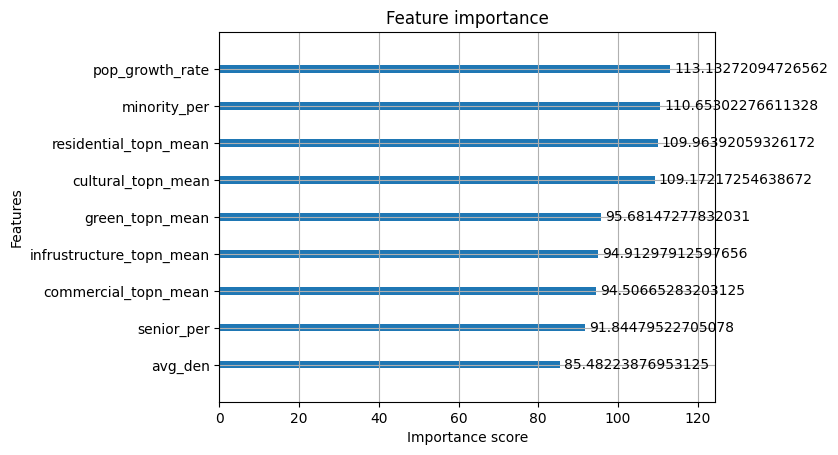

In [ ]:
from xgboost import plot_importance
plot_importance(model, importance_type='cover')

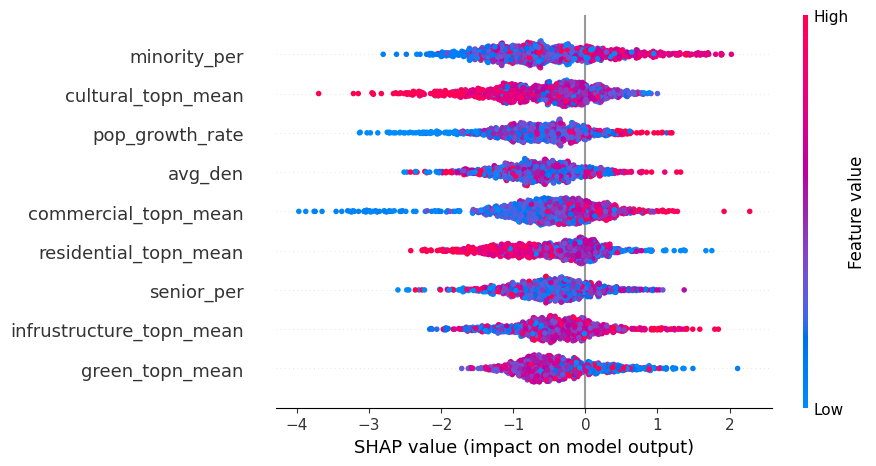

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

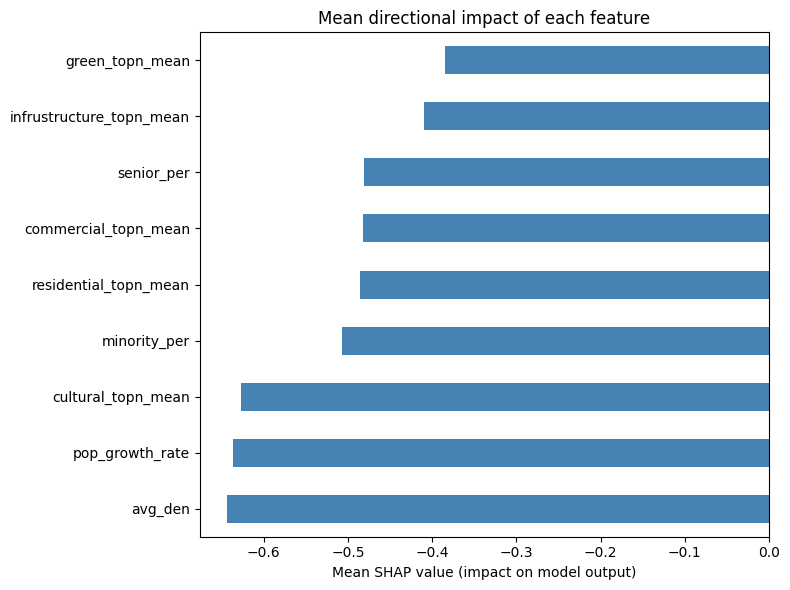

In [ ]:
# shap_values: SHAP 的主对象（假设是 TreeExplainer 得到的）
# X: 输入特征 dataframe

shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 计算每个特征的平均 SHAP 值（带符号）
mean_shap = shap_df.mean().sort_values()

mean_shap.plot(kind='barh', figsize=(8,6), color=(mean_shap > 0).map({True: 'crimson', False: 'steelblue'}))
plt.xlabel("Mean SHAP value (impact on model output)")
plt.title("Mean directional impact of each feature")
plt.tight_layout()
plt.show()

In [ ]:
shap_values.base_values.mean()  # 这是所有 SHAP 值的基准线

np.float32(-0.086433284)

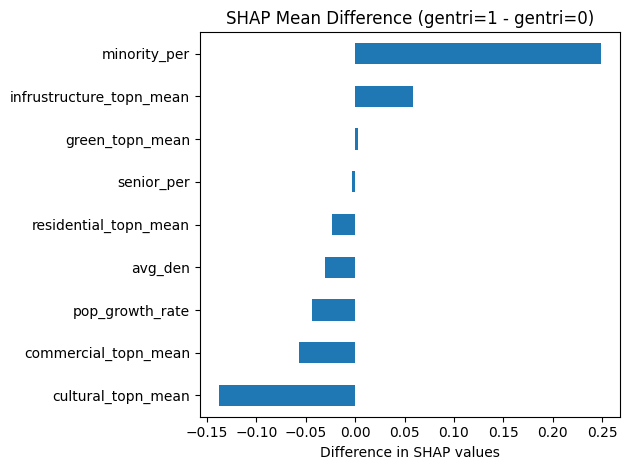

In [ ]:
X_g1 = X[y == 1]
X_g0 = X[y == 0]

shap_g1 = shap_df.loc[y == 1].mean()
shap_g0 = shap_df.loc[y == 0].mean()

diff = shap_g1 - shap_g0
diff.sort_values().plot(kind='barh')
plt.title("SHAP Mean Difference (gentri=1 - gentri=0)")
plt.xlabel("Difference in SHAP values")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# 保存模型
joblib.dump(model, "xgb_model_original.pkl")

['xgb_model_original.pkl']